In [1]:
from fastai import *
from fastai.tabular import *
from fastai.collab import *
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('C:\\Users\\bokhy\\Desktop\\Python\\Python-Projects\\Kaggle\\nyc-taxi-trip-duration\\')

In [3]:
# `parse_dates` will recognize the column is date time
train = pd.read_csv(os.path.join(path, 'train.csv'),parse_dates=['pickup_datetime','dropoff_datetime'])
test = pd.read_csv(os.path.join(path, 'test.csv'),parse_dates=['pickup_datetime'])

In [4]:
train.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [11]:
test.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


## The evaluation metric is RMSLE and not RMSE . 
## Outliers will cause less trouble. We could logtransform our target label and use RMSE during training.

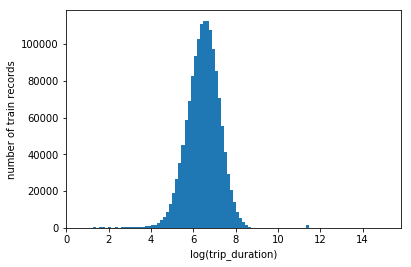

In [4]:
# Log transform the target value 
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [5]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Hour', 'Minute', 'Second','Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
            'weekday','weekofyear']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [6]:
add_datepart(train, "pickup_datetime", drop=False)

In [7]:
add_datepart(test, "pickup_datetime", drop=False)

In [8]:
# Add a few more datetime features
for df in (train,test):
    df['pickup_dt']  = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
    df['pickup_week_hour']  = df['pickup_datetimeweekday'] * 24 + df['pickup_datetimeHour'] 
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

In [9]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeweekday,pickup_datetimeweekofyear,pickup_datetimeElapsed,pickup_dt,pickup_week_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,False,False,False,False,False,0,11,1457976295,6369878.0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,False,False,False,False,False,6,23,1465692215,14085798.0,144


In [ ]:
# Add Pickup Time and Weekend Features
# (source: https://www.kaggle.com/onlyshadow/a-practical-guide-to-ny-taxi-data-0-379)

In [3]:
from datetime import datetime
holiday = pd.read_csv(os.path.join(path, 'NYC_2016Holidays.csv'),sep=';')

In [4]:
holiday.head()

,Day,Date,Holiday
0,Friday,January 01,New Years Day
1,Monday,January 18,Martin Luther King Jr. Day
2,Friday,February 12,Lincoln's Birthday
3,Monday,February 15,Presidents' Day
4,Sunday,May 08,Mother's Day


In [5]:
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]

In [8]:
holidays

[datetime.date(2016, 1, 1),
 datetime.date(2016, 1, 18),
 datetime.date(2016, 2, 12),
 datetime.date(2016, 2, 15),
 datetime.date(2016, 5, 8),
 datetime.date(2016, 5, 30),
 datetime.date(2016, 6, 19),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 9, 5),
 datetime.date(2016, 10, 10),
 datetime.date(2016, 11, 11),
 datetime.date(2016, 11, 24),
 datetime.date(2016, 12, 26),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 11, 8)]

In [19]:
time_train = pd.DataFrame(index = range(len(train)))
time_test = pd.DataFrame(index = range(len(test)))

In [20]:
from datetime import date
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

In [23]:
rest_day,weekend = restday(train.pickup_datetimeYear,train.pickup_datetimeMonth,train.pickup_datetimeDay,holidays)
time_train = time_train.assign(rest_day=rest_day)
time_train = time_train.assign(weekend=weekend)

rest_day,weekend = restday(test.pickup_datetimeYear,test.pickup_datetimeMonth,test.pickup_datetimeDay,holidays)
time_test = time_test.assign(rest_day=rest_day)
time_test = time_test.assign(weekend=weekend)

In [25]:
time_train = time_train.assign(pickup_time = train.pickup_datetimeHour+train.pickup_datetimeMinute/60)
# 7.5 means 7:30 am
time_test = time_test.assign(pickup_time = test.pickup_datetimeHour+test.pickup_datetimeMinute/60)

In [27]:
time_train.to_csv('time_train.csv',index=False)
time_test.to_csv('time_test.csv',index=False)

In [ ]:
# Add Distance Features
# travel distance should be more relevent here. The difficault part is to aquire this feature. 

In [29]:
fastrout1 = pd.read_csv(os.path.join(path, 'fastest_routes_train_part_1.csv'),
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout2 = pd.read_csv(os.path.join(path, 'fastest_routes_train_part_2.csv'),
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout = pd.concat((fastrout1,fastrout2))
fastrout.head()

,id,total_distance,total_travel_time,number_of_steps,step_direction
0,id2875421,2009.1,164.9,5,left|straight|right|straight|arrive
1,id2377394,2513.2,332.0,6,none|right|left|right|left|arrive
2,id3504673,1779.4,235.8,4,left|left|right|arrive
3,id2181028,1614.9,140.1,5,right|left|right|left|arrive
4,id0801584,1393.5,189.4,5,right|right|right|left|arrive


In [30]:
# Generate a feature for number of right turns and left turns. 
# Note that I didn't count 'slight right' and 'slight left'.
right_turn = []
left_turn = []
right_turn+= list(map(lambda x:x.count('right')-x.count('slight right'),fastrout.step_direction))
left_turn += list(map(lambda x:x.count('left')-x.count('slight left'),fastrout.step_direction))

In [31]:
# Let's combine the features that seems to be relevent to trip_duration
osrm_data = fastrout[['id','total_distance','total_travel_time','number_of_steps']]
osrm_data = osrm_data.assign(right_steps=right_turn)
osrm_data = osrm_data.assign(left_steps=left_turn)
osrm_data.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2009.1,164.9,5,1,1
1,id2377394,2513.2,332.0,6,2,2
2,id3504673,1779.4,235.8,4,1,2
3,id2181028,1614.9,140.1,5,2,2
4,id0801584,1393.5,189.4,5,3,1


In [32]:
train = train.join(osrm_data.set_index('id'), on='id')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeHour,pickup_datetimeMinute,pickup_datetimeSecond,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeweekday,pickup_datetimeweekofyear,pickup_datetimeElapsed,pickup_dt,pickup_week_hour,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,6.122493,2016,3,11,14,17,24,55,0,74,False,False,False,False,False,False,0,11,1457976295,6369878.0,17,2009.1,164.9,5.0,1.0,1.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6.498282,2016,6,23,12,0,43,35,6,164,False,False,False,False,False,False,6,23,1465692215,14085798.0,144,2513.2,332.0,6.0,2.0,2.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,7.661527,2016,1,3,19,11,35,24,1,19,False,False,False,False,False,False,1,3,1453203324,1596907.0,35,11060.8,767.6,16.0,5.0,4.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,6.063785,2016,4,14,6,19,32,31,2,97,False,False,False,False,False,False,2,14,1459971151,8364734.0,67,1779.4,235.8,4.0,1.0,2.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,6.077642,2016,3,12,26,13,30,55,5,86,False,False,False,False,False,False,5,12,1458999055,7392638.0,133,1614.9,140.1,5.0,2.0,2.0


In [33]:
osrm_test = pd.read_csv(os.path.join(path, 'fastest_routes_test.csv'))
right_turn= list(map(lambda x:x.count('right')-x.count('slight right'),osrm_test.step_direction))
left_turn = list(map(lambda x:x.count('left')-x.count('slight left'),osrm_test.step_direction))

osrm_test = osrm_test[['id','total_distance','total_travel_time','number_of_steps']]
osrm_test = osrm_test.assign(right_steps=right_turn)
osrm_test = osrm_test.assign(left_steps=left_turn)
osrm_test.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.1,200.2,7,2,3
1,id3274209,1427.1,141.5,2,0,0
2,id2756455,2312.3,324.6,9,4,4
3,id3684027,931.8,84.2,4,2,1
4,id3101285,2501.7,294.7,8,3,3


In [34]:
test = test.join(osrm_test.set_index('id'), on='id')
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeHour,pickup_datetimeMinute,pickup_datetimeSecond,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeweekday,pickup_datetimeweekofyear,pickup_datetimeElapsed,pickup_dt,pickup_week_hour,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,2016,6,26,30,23,59,58,3,182,True,False,True,False,False,False,3,26,1467331198,15724776.0,95,3795.9,424.6,4,1,1
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,2016,6,26,30,23,59,53,3,182,True,False,True,False,False,False,3,26,1467331193,15724771.0,95,2904.5,200.0,4,1,1
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,2016,6,26,30,23,59,47,3,182,True,False,True,False,False,False,3,26,1467331187,15724765.0,95,1499.5,193.2,4,1,1
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,2016,6,26,30,23,59,41,3,182,True,False,True,False,False,False,3,26,1467331181,15724759.0,95,7023.9,494.8,11,3,3
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,2016,6,26,30,23,59,33,3,182,True,False,True,False,False,False,3,26,1467331173,15724751.0,95,1108.2,103.2,4,1,2


In [35]:
osrm_data = train[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]
osrm_test = test[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]

In [36]:
train.to_csv('osrm_train.csv',index=False,
            columns = ['total_distance','total_travel_time','number_of_steps','right_steps','left_steps'])
test.to_csv('osrm_test.csv',index=False,
            columns = ['total_distance','total_travel_time','number_of_steps','right_steps','left_steps'])

In [ ]:
# Calculate Distance
# pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays. 
# We extraxt the middle of the path as a feature as well.

# (source: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367)

# Haversine distance: the direct distance of two GPS location, taking into account that the earth is round.
# Manhattan distance: the usual L1 distance, here the haversine distance is used to calculate each coordinate of distance.
# Bearing: The direction of the trip. Using radian as unit. (I must admit that I am not fully understand the formula. I have starring at it for a long time but can't come up anything. If anyone can help explain that will do me a big favor.)

In [37]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [38]:
List_dist = []
for df in (train,test):
    lat1, lng1, lat2, lng2 = (df['pickup_latitude'].values, df['pickup_longitude'].values, 
                              df['dropoff_latitude'].values,df['dropoff_longitude'].values)
    dist = pd.DataFrame(index=range(len(df)))
    dist = dist.assign(haversind_dist = haversine_array(lat1, lng1, lat2, lng2))
    dist = dist.assign(manhattan_dist = dummy_manhattan_distance(lat1, lng1, lat2, lng2))
    dist = dist.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))
    List_dist.append(dist)
Other_dist_train,Other_dist_test = List_dist

In [40]:
Other_dist_train.to_csv('Other_dist_train.csv',index=False)
Other_dist_test.to_csv('Other_dist_test.csv',index=False)

In [ ]:
# Add Weather Data
# (Source): https://www.kaggle.com/cabaki/knycmetars2016

In [48]:
weather = pd.read_csv(os.path.join(path, 'KNYC_Metars.csv'), parse_dates=['Time'])
weather.head()

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast


In [49]:
weather['snow']= 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['pickup_datetimeMonth'] = weather['Time'].dt.month
weather['pickup_datetimeDay'] = weather['Time'].dt.day
weather['pickup_datetimeHour'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016][['pickup_datetimeMonth','pickup_datetimeDay','pickup_datetimeHour','Temp.','Precip','snow','Visibility']]

In [50]:
weather.head()

,pickup_datetimeMonth,pickup_datetimeDay,pickup_datetimeHour,Temp.,Precip,snow,Visibility
22,1,1,0,5.6,0.0,0,16.1
23,1,1,1,5.6,0.0,0,16.1
24,1,1,2,5.6,0.0,0,16.1
25,1,1,3,5.0,0.0,0,16.1
26,1,1,4,5.0,0.0,0,16.1


In [52]:
# Merge the snow infomation to our data set.
train = pd.merge(train, weather, on = ['pickup_datetimeMonth', 'pickup_datetimeDay', 'pickup_datetimeHour'], how = 'left')
test = pd.merge(test, weather, on = ['pickup_datetimeMonth', 'pickup_datetimeDay', 'pickup_datetimeHour'], how = 'left')

In [53]:
weather_train = train[['Temp.','Precip','snow','Visibility']]
weather_test = test[['Temp.','Precip','snow','Visibility']]
weather_train.to_csv('weather_train.csv',index=False)
weather_test.to_csv('weather_test.csv',index=False)

In [10]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeweekday,pickup_datetimeweekofyear,pickup_datetimeElapsed,pickup_dt,pickup_week_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,False,False,False,False,False,0,11,1457976295,6369878.0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,False,False,False,False,False,6,23,1465692215,14085798.0,144


In [ ]:
# Prepare One Merged Data

In [10]:
traindf = train[['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag',
                'log_trip_duration',
                'pickup_datetimeYear','pickup_datetimeMonth',
                'pickup_datetimeWeek','pickup_datetimeDay','pickup_datetimeHour','pickup_datetimeMinute',
                'pickup_datetimeSecond','pickup_datetimeDayofweek','pickup_datetimeDayofyear','pickup_datetimeIs_month_end',
                'pickup_datetimeIs_month_start','pickup_datetimeIs_quarter_end','pickup_datetimeIs_quarter_start',
                'pickup_datetimeIs_year_end','pickup_datetimeIs_year_start','pickup_datetimeweekday',
                'pickup_datetimeweekofyear','pickup_datetimeElapsed','pickup_dt']]

testdf = test[['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag','pickup_datetimeYear','pickup_datetimeMonth',
                'pickup_datetimeWeek','pickup_datetimeDay','pickup_datetimeHour','pickup_datetimeMinute',
                'pickup_datetimeSecond','pickup_datetimeDayofweek','pickup_datetimeDayofyear','pickup_datetimeIs_month_end',
                'pickup_datetimeIs_month_start','pickup_datetimeIs_quarter_end','pickup_datetimeIs_quarter_start',
                'pickup_datetimeIs_year_end','pickup_datetimeIs_year_start','pickup_datetimeweekday',
                'pickup_datetimeweekofyear','pickup_datetimeElapsed','pickup_dt']]

In [11]:
print('There are %d samples in the test data'%len(testdf))

There are 625134 samples in the test data


In [12]:
# Load Pre-Processed and saved dataset
time_train      = pd.read_csv('time_train.csv')
weather_train   = pd.read_csv('weather_train.csv')
osrm_train       = pd.read_csv('osrm_train.csv')
Other_dist_train = pd.read_csv('Other_dist_train.csv')

time_test       = pd.read_csv('time_test.csv')
weather_test    = pd.read_csv('weather_test.csv')
osrm_test       = pd.read_csv('osrm_test.csv')
Other_dist_test = pd.read_csv('Other_dist_test.csv')

In [13]:
traindf  = pd.concat([traindf,time_train,weather_train,osrm_train,Other_dist_train],axis=1)
testdf   = pd.concat([testdf,time_test,weather_test,osrm_test,Other_dist_test],axis=1)

In [71]:
np.all(traindf.keys())

'bearing'

In [65]:
if np.all(traindf.keys()==testdf.keys()):
    print('Good! The keys of training feature is identical to those of test feature')
else:
    print('Oops, something is wrong, keys in training and testing are not matching')   

ValueError: Lengths must match to compare

In [14]:
pd.set_option('display.max_columns', None)

In [15]:
traindf.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeHour,pickup_datetimeMinute,pickup_datetimeSecond,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeweekday,pickup_datetimeweekofyear,pickup_datetimeElapsed,pickup_dt,rest_day,weekend,pickup_time,Temp.,Precip,snow,Visibility,total_distance,total_travel_time,number_of_steps,right_steps,left_steps,haversind_dist,manhattan_dist,bearing
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,6.122493,2016,3,11,14,17,24,55,0,74,False,False,False,False,False,False,0,11,1457976295,6369878.0,False,False,17.400000,4.4,0.3,0.0,8.0,2009.1,164.9,5.0,1.0,1.0,1.498521,1.735433,99.970196
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6.498282,2016,6,23,12,0,43,35,6,164,False,False,False,False,False,False,6,23,1465692215,14085798.0,True,True,0.716667,28.9,0.0,0.0,16.1,2513.2,332.0,6.0,2.0,2.0,1.805507,2.430506,-117.153768
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661527,2016,1,3,19,11,35,24,1,19,False,False,False,False,False,False,1,3,1453203324,1596907.0,False,False,11.583333,-6.7,0.0,0.0,16.1,11060.8,767.6,16.0,5.0,4.0,6.385098,8.203575,-159.680165
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,6.063785,2016,4,14,6,19,32,31,2,97,False,False,False,False,False,False,2,14,1459971151,8364734.0,False,False,19.533333,7.2,0.0,0.0,16.1,1779.4,235.8,4.0,1.0,2.0,1.485498,1.661331,-172.737700
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,6.077642,2016,3,12,26,13,30,55,5,86,False,False,False,False,False,False,5,12,1458999055,7392638.0,True,True,13.500000,9.4,0.0,0.0,16.1,1614.9,140.1,5.0,2.0,2.0,1.188588,1.199457,179.473585


In [16]:
testdf.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeHour,pickup_datetimeMinute,pickup_datetimeSecond,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeweekday,pickup_datetimeweekofyear,pickup_datetimeElapsed,pickup_dt,rest_day,weekend,pickup_time,Temp.,Precip,snow,Visibility,total_distance,total_travel_time,number_of_steps,right_steps,left_steps,haversind_dist,manhattan_dist,bearing
0,1,1,-73.988129,40.732029,-73.990173,40.756680,0,2016,6,26,30,23,59,58,3,182,True,False,True,False,False,False,3,26,1467331198,15724776.0,False,False,23.983333,24.4,0.0,0.0,16.1,3795.9,424.6,4,1,1,2.746426,2.913304,-3.595224
1,1,1,-73.964203,40.679993,-73.959808,40.655403,0,2016,6,26,30,23,59,53,3,182,True,False,True,False,False,False,3,26,1467331193,15724771.0,False,False,23.983333,24.4,0.0,0.0,16.1,2904.5,200.0,4,1,1,2.759239,3.104805,172.278835
2,1,1,-73.997437,40.737583,-73.986160,40.729523,0,2016,6,26,30,23,59,47,3,182,True,False,True,False,False,False,3,26,1467331187,15724765.0,False,False,23.983333,24.4,0.0,0.0,16.1,1499.5,193.2,4,1,1,1.306155,1.846340,133.326248
3,2,1,-73.956070,40.771900,-73.986427,40.730469,0,2016,6,26,30,23,59,41,3,182,True,False,True,False,False,False,3,26,1467331181,15724759.0,False,False,23.983333,24.4,0.0,0.0,16.1,7023.9,494.8,11,3,3,5.269088,7.163347,-150.956833
4,1,1,-73.970215,40.761475,-73.961510,40.755890,0,2016,6,26,30,23,59,33,3,182,True,False,True,False,False,False,3,26,1467331173,15724751.0,False,False,23.983333,24.4,0.0,0.0,16.1,1108.2,103.2,4,1,2,0.960842,1.354164,130.260381


In [ ]:
# Modeling

In [17]:
procs=[FillMissing, Categorify, Normalize]

In [18]:
dep_var = 'log_trip_duration'
cat_names = ['vendor_id','store_and_fwd_flag','pickup_datetimeYear','pickup_datetimeMonth','pickup_datetimeWeek',
            'pickup_datetimeDay','pickup_datetimeHour','pickup_datetimeMinute','pickup_datetimeSecond',
            'pickup_datetimeDayofweek','pickup_datetimeDayofyear','pickup_datetimeIs_month_end',
            'pickup_datetimeIs_month_start','pickup_datetimeIs_quarter_end','pickup_datetimeIs_quarter_start',
            'pickup_datetimeIs_year_end','pickup_datetimeIs_year_start','pickup_datetimeweekday','pickup_datetimeweekofyear',
            'rest_day','weekend','number_of_steps','right_steps','left_steps']
cont_names = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
             'pickup_dt','pickup_time','Temp.','Precip','snow','Visibility','total_distance',
             'total_travel_time','haversind_dist','manhattan_dist','bearing']

In [19]:
data = (TabularList.from_df(traindf, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(0.2)
                           .label_from_df(cols = dep_var).add_test(testdf) 
                           .databunch())

In [21]:
data.show_batch()

vendor_id,store_and_fwd_flag,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeHour,pickup_datetimeMinute,pickup_datetimeSecond,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeweekday,pickup_datetimeweekofyear,rest_day,weekend,number_of_steps,right_steps,left_steps,Temp._na,Precip_na,snow_na,Visibility_na,total_distance_na,total_travel_time_na,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_dt,pickup_time,Temp.,Precip,snow,Visibility,total_distance,total_travel_time,haversind_dist,manhattan_dist,bearing,target
2,0,2016,1,4,30,1,37,51,5,30,False,False,False,False,False,False,5,4,True,True,9.0,3.0,2.0,False,False,False,False,False,False,-0.5058,-0.3599,-0.2756,-0.2284,-0.9058,-1.2094,-1.9481,-1.2819,-0.1460,-0.0946,0.4431,-0.1946,0.2883,-0.1830,-0.1900,1.6909,6.683361
2,0,2016,5,20,16,10,55,34,0,137,False,False,False,False,False,False,0,20,False,False,8.0,2.0,2.0,False,False,False,True,False,False,0.2553,0.1485,0.7536,-0.1937,0.7716,0.8730,-0.4967,-0.2266,-0.1460,-0.0946,0.4431,-0.2820,-0.2810,-0.2791,-0.3258,-0.6143,6.4052286
2,0,2016,6,25,26,15,2,16,6,178,False,False,False,False,False,False,6,25,True,True,15.0,5.0,4.0,False,False,False,False,False,False,2.5385,-0.0138,-0.2611,-0.5766,-1.1838,1.6714,0.1458,2.0160,-0.1460,-0.0946,-0.6066,0.7440,1.0179,0.3916,0.4942,-1.1462,6.891626
2,0,2016,2,8,27,0,32,18,5,58,False,False,False,False,False,False,5,8,True,True,6.0,2.0,2.0,False,False,False,False,False,False,0.2553,-0.3593,-0.4060,-0.4576,-0.4497,-0.6674,-2.1172,-1.4578,-0.1460,-0.0946,0.4431,-0.6635,-0.7302,-0.6427,-0.6355,-0.8811,5.370638
2,0,2016,3,10,11,8,19,46,4,71,False,False,False,False,False,False,4,10,False,False,3.0,0.0,1.0,False,False,False,False,False,False,-0.5058,0.1546,0.7034,-0.0246,0.0770,-0.4090,-0.9025,0.3121,-0.1460,-0.0946,0.4431,-0.3931,-0.4886,-0.2211,-0.1926,-1.3083,6.461468


In [22]:
max_y = np.max(traindf['log_trip_duration'])
y_range = torch.tensor([0, max_y], device=defaults.device)
y_range

tensor([ 0.0000, 15.0758], device='cuda:0')

In [23]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics= [exp_rmspe,rmse])
# learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


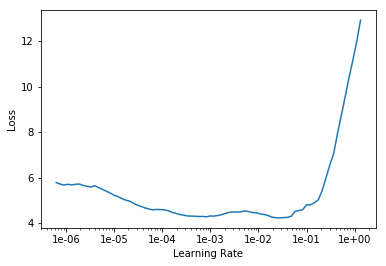

In [25]:
learn.recorder.plot()

In [26]:
lr = 1e-2

In [27]:
learn.fit_one_cycle(2, slice(lr), wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,root_mean_squared_error,time
0,0.210177,0.213714,10.435072,0.442845,35:01
1,0.207626,0.177628,0.644063,0.401897,20:04


epoch,train_loss,valid_loss,exp_rmspe,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 9.12E-08


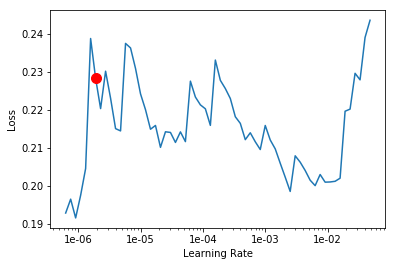

In [28]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [30]:
gc.collect()

22

In [31]:
learn.fit_one_cycle(4, slice(1e-6), moms=(0.8,0.7))

epoch,train_loss,valid_loss,exp_rmspe,root_mean_squared_error,time
0,0.190645,0.177135,0.648825,0.401378,20:16
1,0.197896,0.178429,0.733402,0.402591,17:45
2,0.178606,0.179710,0.698649,0.404556,22:58
3,0.191253,0.184694,0.731157,0.410950,18:35


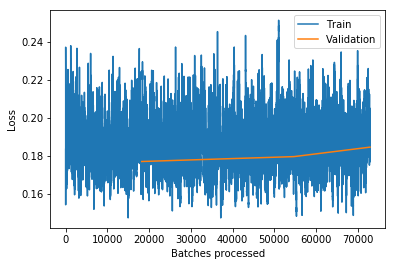

In [32]:
learn.recorder.plot_losses()

In [32]:
# learn.save('NY_Taxi_Kaggle')

In [33]:
# learn.load('NY_Taxi_Kaggle');
# or 
# learn.export()
# learn = load_learner(df_test)

In [33]:
learn.export()

In [85]:
test_data = TabularList.from_df(testdf, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)

In [89]:
learner = load_learner(path ,test = test_data)

KeyError: 'data'

In [ ]:
# Submission

In [72]:
pred_test, y = learner.get_preds(ds_type=DatasetType.Test)

In [73]:
pred_test

tensor([[6.5540],
        [6.3470],
        [5.9674],
        ...,
        [7.2897],
        [7.5139],
        [6.9533]])

In [74]:
y

tensor([0, 0, 0,  ..., 0, 0, 0])

In [78]:
len(pred_test)

625134

In [79]:
pred_test1 = pred_test.numpy()

In [80]:
pred_test1

array([[6.55397 ],
       [6.347031],
       [5.96743 ],
       [6.859299],
       ...,
       [7.078001],
       [7.289652],
       [7.513936],
       [6.953299]], dtype=float32)

In [81]:
test_result = np.exp(pred_test1)-1
print(test_result[:10])

[[ 701.02594]
 [ 569.7956 ]
 [ 389.50082]
 [ 951.69916]
 [ 313.00345]
 [ 842.90063]
 [1075.1621 ]
 [ 774.80975]
 [2213.586  ]
 [ 469.84238]]


In [83]:
test_result

array([[ 701.02594],
       [ 569.7956 ],
       [ 389.50082],
       [ 951.69916],
       ...,
       [1184.5962 ],
       [1464.0605 ],
       [1832.4149 ],
       [1045.5968 ]], dtype=float32)

In [84]:
submission = pd.DataFrame({'id': test.id, 'trip_duration': test_result[:, 0]})
submission.to_csv('NY_Taxi_Kaggle.csv', index=False)

In [116]:
for col_to_delete in testdf.columns[~testdf.columns.isin(traindf.columns)]:
    del testdf[col_to_delete]

In [124]:
traindf = traindf.reindex(sorted(traindf.columns), axis=1)

In [125]:
testdf = testdf.reindex(sorted(testdf.columns), axis=1)

In [204]:
traindf.head()

,Precip,Temp.,Visibility,bearing,dropoff_latitude,dropoff_longitude,haversind_dist,left_steps,log_trip_duration,manhattan_dist,number_of_steps,passenger_count,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeElapsed,pickup_datetimeHour,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeMinute,pickup_datetimeMonth,pickup_datetimeSecond,pickup_datetimeWeek,pickup_datetimeYear,pickup_datetimeweekday,pickup_datetimeweekofyear,pickup_dt,pickup_latitude,pickup_longitude,pickup_time,rest_day,right_steps,snow,store_and_fwd_flag,total_distance,total_travel_time,vendor_id,weekend
0,0.3,4.4,8.0,99.970196,40.765602,-73.964630,1.498521,1.0,6.122493,1.735433,5.0,1,14,0,74,1457976295,17,False,False,False,False,False,False,24,3,55,11,2016,0,11,6369878.0,40.767937,-73.982155,17.400000,False,1.0,0.0,0,2009.1,164.9,2,False
1,0.0,28.9,16.1,-117.153768,40.731152,-73.999481,1.805507,2.0,6.498282,2.430506,6.0,1,12,6,164,1465692215,0,False,False,False,False,False,False,43,6,35,23,2016,6,23,14085798.0,40.738564,-73.980415,0.716667,True,2.0,0.0,0,2513.2,332.0,1,True
2,0.0,-6.7,16.1,-159.680165,40.710087,-74.005333,6.385098,4.0,7.661527,8.203575,16.0,1,19,1,19,1453203324,11,False,False,False,False,False,False,35,1,24,3,2016,1,3,1596907.0,40.763939,-73.979027,11.583333,False,5.0,0.0,0,11060.8,767.6,2,False
3,0.0,7.2,16.1,-172.737700,40.706718,-74.012268,1.485498,2.0,6.063785,1.661331,4.0,1,6,2,97,1459971151,19,False,False,False,False,False,False,32,4,31,14,2016,2,14,8364734.0,40.719971,-74.010040,19.533333,False,1.0,0.0,0,1779.4,235.8,2,False
4,0.0,9.4,16.1,179.473585,40.782520,-73.972923,1.188588,2.0,6.077642,1.199457,5.0,1,26,5,86,1458999055,13,False,False,False,False,False,False,30,3,55,12,2016,5,12,7392638.0,40.793209,-73.973053,13.500000,True,2.0,0.0,0,1614.9,140.1,2,True


In [205]:
testdf.head()

,Precip,Temp.,Visibility,bearing,dropoff_latitude,dropoff_longitude,haversind_dist,left_steps,manhattan_dist,number_of_steps,passenger_count,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeElapsed,pickup_datetimeHour,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeMinute,pickup_datetimeMonth,pickup_datetimeSecond,pickup_datetimeWeek,pickup_datetimeYear,pickup_datetimeweekday,pickup_datetimeweekofyear,pickup_dt,pickup_latitude,pickup_longitude,pickup_time,rest_day,right_steps,snow,store_and_fwd_flag,total_distance,total_travel_time,vendor_id,weekend
0,0.0,24.4,16.1,-3.595224,40.756680,-73.990173,2.746426,1,2.913304,4,1,30,3,182,1467331198,23,True,False,True,False,False,False,59,6,58,26,2016,3,26,15724776.0,40.732029,-73.988129,23.983333,False,1,0.0,0,3795.9,424.6,1,False
1,0.0,24.4,16.1,172.278835,40.655403,-73.959808,2.759239,1,3.104805,4,1,30,3,182,1467331193,23,True,False,True,False,False,False,59,6,53,26,2016,3,26,15724771.0,40.679993,-73.964203,23.983333,False,1,0.0,0,2904.5,200.0,1,False
2,0.0,24.4,16.1,133.326248,40.729523,-73.986160,1.306155,1,1.846340,4,1,30,3,182,1467331187,23,True,False,True,False,False,False,59,6,47,26,2016,3,26,15724765.0,40.737583,-73.997437,23.983333,False,1,0.0,0,1499.5,193.2,1,False
3,0.0,24.4,16.1,-150.956833,40.730469,-73.986427,5.269088,3,7.163347,11,1,30,3,182,1467331181,23,True,False,True,False,False,False,59,6,41,26,2016,3,26,15724759.0,40.771900,-73.956070,23.983333,False,3,0.0,0,7023.9,494.8,2,False
4,0.0,24.4,16.1,130.260381,40.755890,-73.961510,0.960842,2,1.354164,4,1,30,3,182,1467331173,23,True,False,True,False,False,False,59,6,33,26,2016,3,26,15724751.0,40.761475,-73.970215,23.983333,False,1,0.0,0,1108.2,103.2,1,False


In [177]:
# Split the labeled data frame into two sets: features and target
X = traindf
z = traindf.log_trip_duration.values

In [178]:
# Split the labeled data frame into two sets to train then test the models
import xgboost as xgb
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)

In [179]:
Xtrain.shape, Xval.shape, Ztrain.shape, Zval.shape

((1166915, 42), (291729, 42), (1166915,), (291729,))

In [180]:
del Xtrain['log_trip_duration']

In [181]:
del Xval['log_trip_duration']

In [182]:
Xcv,Xv,Zcv,Zv = train_test_split(Xval, Zval, test_size=0.5, random_state=623)

In [186]:
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xcv   , label=Zcv)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [203]:
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval  , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [206]:
parms = {'max_depth':30, #maximum depth of a tree
         'objective':'reg:squarederror',
         'eta'      :0.1,
         'subsample':0.8, #SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term, >1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10,
         'nthread'  :3, # number of cpu core to use
         'eval_metric': 'rmse'}  

model = xgb.train(parms, data_tr, num_boost_round=1000, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=100)

print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

[0]	train-rmse:5.42108	valid-rmse:5.42162
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[100]	train-rmse:0.161157	valid-rmse:0.37736
Stopping. Best iteration:
[102]	train-rmse:0.159685	valid-rmse:0.377338

score = 0.37734, n_boost_round =102.


In [207]:
data_test = xgb.DMatrix(testdf)

In [208]:
ztest = model.predict(data_test)

In [209]:
ztest

array([6.813537, 6.308863, 5.891332, 6.886916, ..., 7.312615, 7.345081, 7.736618, 7.07045 ], dtype=float32)

In [210]:
ytest = np.exp(ztest)-1
print(ytest[:10])

[ 909.0842   548.42     360.88687  978.37604  444.39194  811.62805 1520.6316  1066.7684  2356.645    472.3472 ]


In [211]:
submission = pd.DataFrame({'id': test.id, 'trip_duration': ytest})
submission.to_csv('NY_Taxi_Kaggle.csv', index=False)

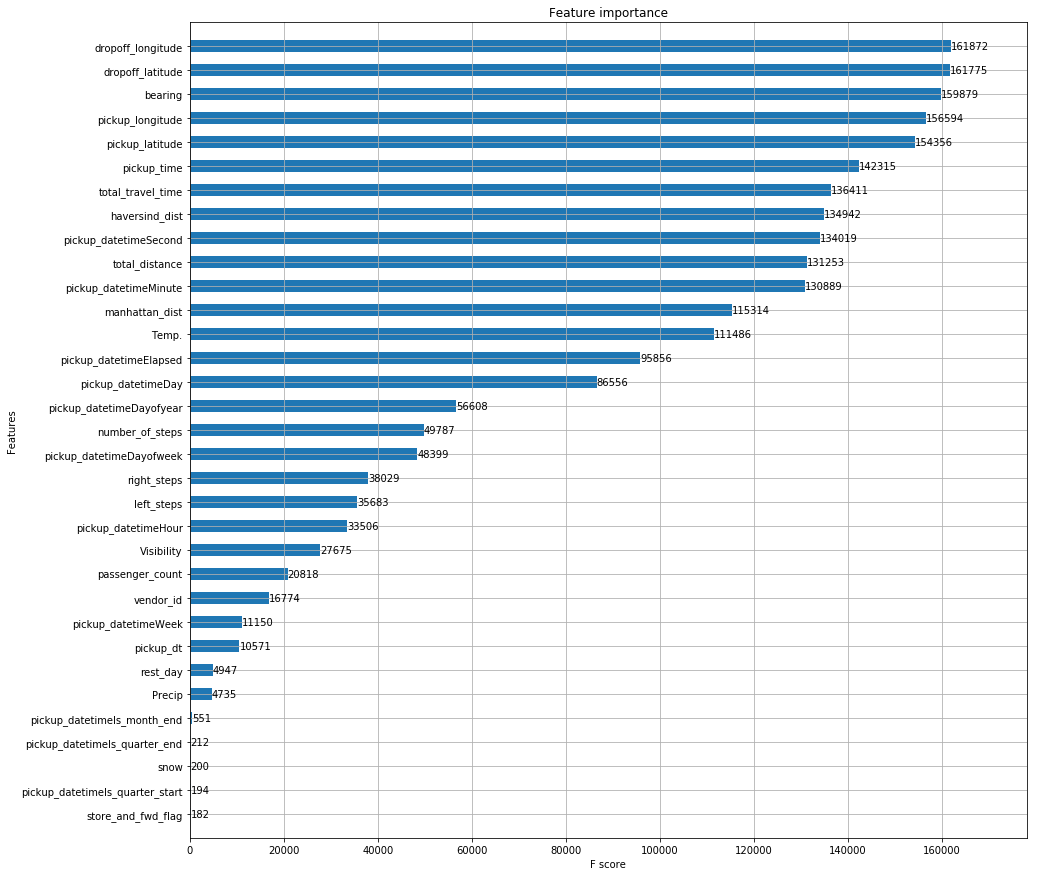

In [212]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(model,ax = axes,height =0.5)
plt.show();plt.close()